<a href="https://www.kaggle.com/code/klyushnik/simple-ensembling-technik?scriptVersionId=192991423" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

from ydata_profiling import ProfileReport

from sklearn.model_selection import (cross_val_score, train_test_split,
                                     StratifiedKFold, 
                                     KFold, StratifiedGroupKFold, GridSearchCV)
from sklearn import metrics

from sklearn.metrics import (roc_curve, auc, roc_auc_score,matthews_corrcoef, accuracy_score)
from sklearn.preprocessing import (QuantileTransformer, StandardScaler, 
                                   PowerTransformer, MaxAbsScaler,
                                   MinMaxScaler, RobustScaler,LabelEncoder,OneHotEncoder,
                                   StandardScaler, label_binarize, PolynomialFeatures,
                                  OrdinalEncoder)
from sklearn.ensemble import (AdaBoostClassifier,  HistGradientBoostingClassifier,
                              GradientBoostingClassifier,RandomForestClassifier,
                             VotingClassifier, StackingClassifier,ExtraTreesClassifier,
                             BaggingClassifier)
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import lightgbm as lgb
from numba import jit
from statsmodels.stats.outliers_influence import variance_inflation_factor

from mlxtend.classifier import StackingCVClassifier 

import statsmodels.api as sm

from phik.report import plot_correlation_matrix
from phik import report

import optuna

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [2]:
random_state = 42
n_splits = 5

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

def plot_box_hist(x):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=12, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    return plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

def create_calibrated_classifier(base_model, method='sigmoid', n_splits=n_splits, random_state=random_state):
    return CalibratedClassifierCV(
        base_model,
        method=method,
        cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    )

# Welcome to my github

https://github.com/Alexsandrrus/projekts-Kaggle

![Mushroom-Classification-1.png](https://projectsbasedlearning.com/wp-content/uploads/2021/02/Mushroom-Classification-1.png)

**Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.**

**Your Goal: The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.**

**Evaluation**
Submissions are evaluated using the Matthews correlation coefficient (MCC).

![images?q=tbn:ANd9GcRWNx3Lu_KMTgbC9UaBhmfLz8VIJbGOe2FXEw&s](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRWNx3Lu_KMTgbC9UaBhmfLz8VIJbGOe2FXEw&s)

![images?q=tbn:ANd9GcTDt9OUgl6qvDprMeFP2frGQeejQ1eocJ94Pg&s](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTDt9OUgl6qvDprMeFP2frGQeejQ1eocJ94Pg&s)

# Load data

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

print(f'Shape of data *train* {train.shape}, *test* {test.shape}')

Shape of data *train* (3116945, 22), *test* (2077964, 21)


In [4]:
train.head(4)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u


# ProfileReport

In [5]:
# profile = ProfileReport(train, title="Profiling Report")
# profile

- does-bruise-or-bleed is highly imbalanced (85.7%)
- gill-spacing is highly imbalanced (80.6%)
- stem-root is highly imbalanced (66.8%)
- veil-type is highly imbalanced (99.8%)
- veil-color is highly imbalanced (69.8%)
- has-ring is highly imbalanced (82.4%)
- ring-type is highly imbalanced (79.3%)
- spore-print-color is highly imbalanced (56.6%)
- cap-surface has 671023 (21.5%) missing values
- gill-attachment has 523936 (16.8%) missing values
- gill-spacing has 1258435 (40.4%) missing values
- stem-root has 2757023 (88.5%) missing values
- stem-surface has 1980861 (63.6%) missing values
- veil-type has 2957493 (94.9%) missing values
- veil-color has 2740947 (87.9%) missing values
- ring-type has 128880 (4.1%) missing values
- spore-print-color has 2849682 (91.4%) missing values

# Preprocess

In [6]:
print('Missing values:')
print()
print('train')
display(train.isna().sum())
print()
print('test')
display(test.isna().sum())

Missing values:

train


id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64


test


id                            0
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                   49
stem-height                   1
stem-width                    0
stem-root               1838012
stem-surface            1321488
stem-color                   21
veil-type               1971545
veil-color              1826124
has-ring                     19
ring-type                 86195
spore-print-color       1899617
habitat                      25
season                        0
dtype: int64

# EDA

In [7]:
plot_col = train.select_dtypes(include=[np.number]).columns

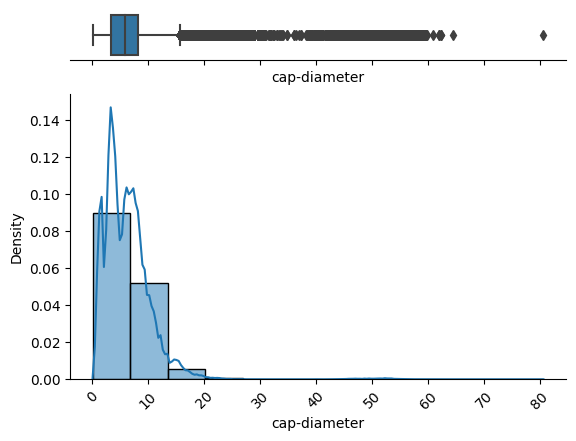

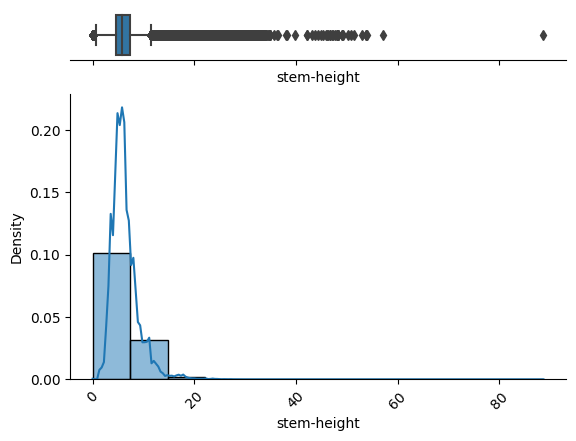

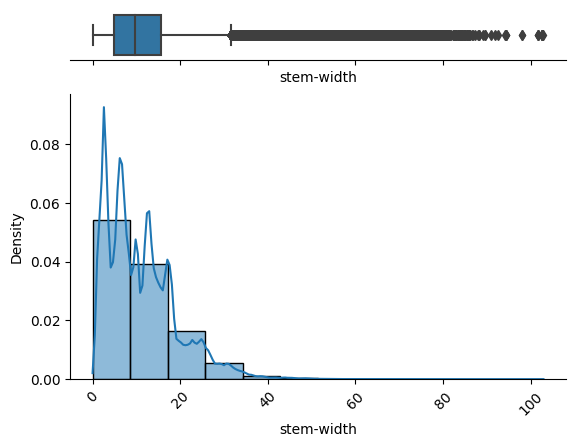

In [8]:
for i in plot_col[1:]:
    plot_box_hist(train[i])

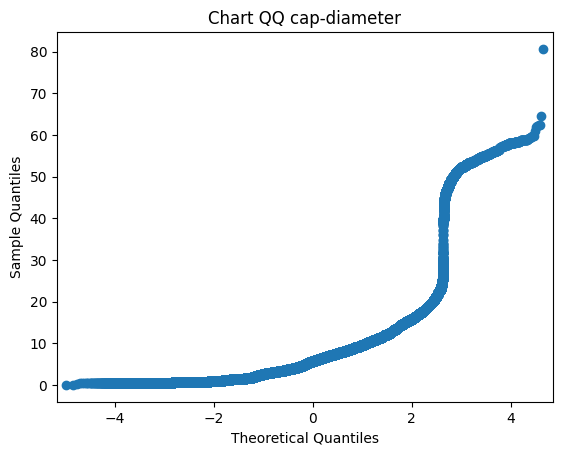

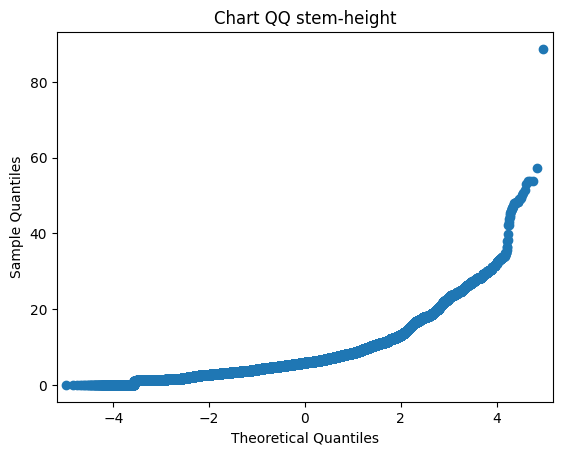

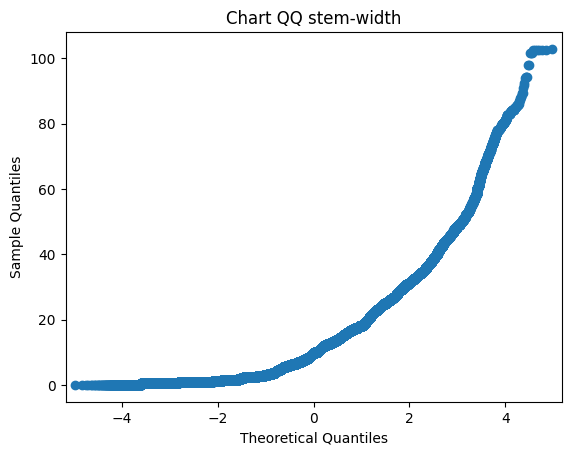

In [9]:
for i in plot_col[1:]:
    sm.qqplot(train[i])
    plt.title(f'Chart QQ {i}')
    plt.show()

**Basically we have a bimodal distribution**

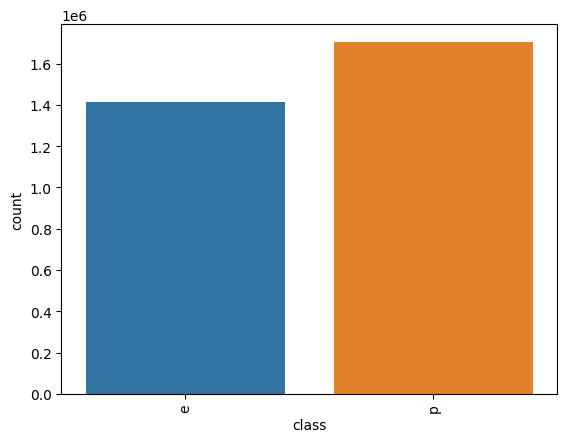

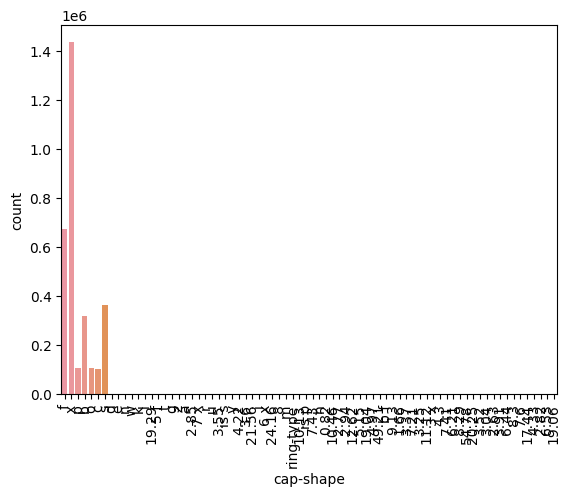

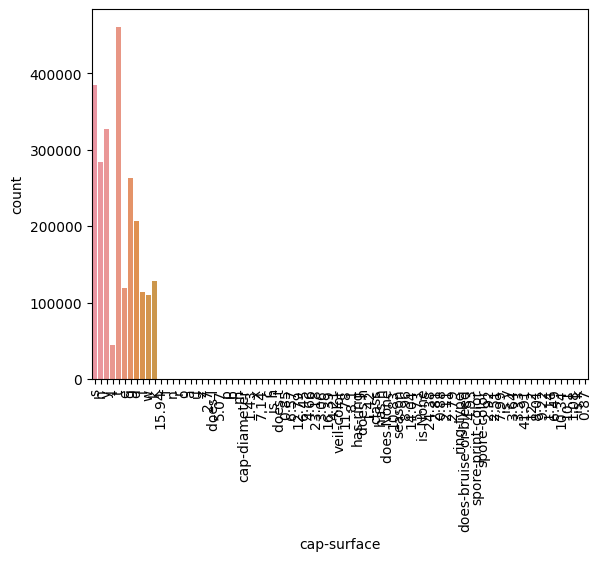

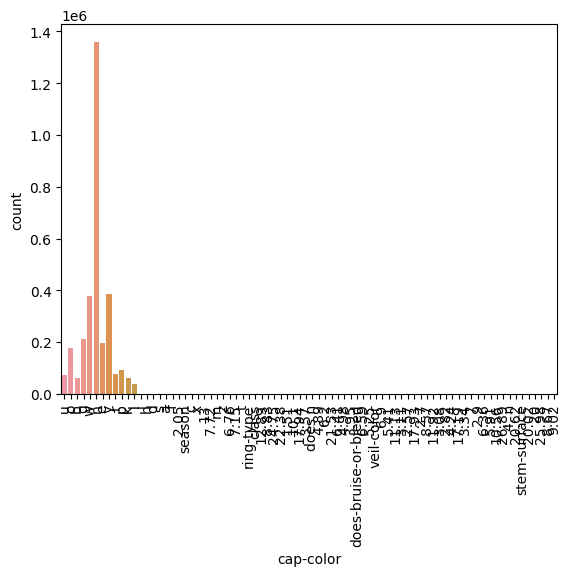

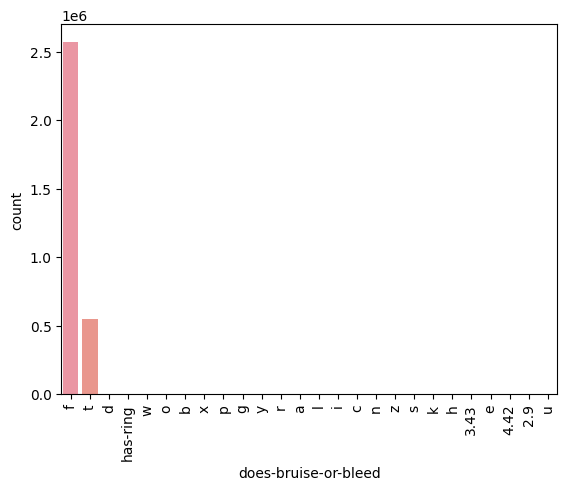

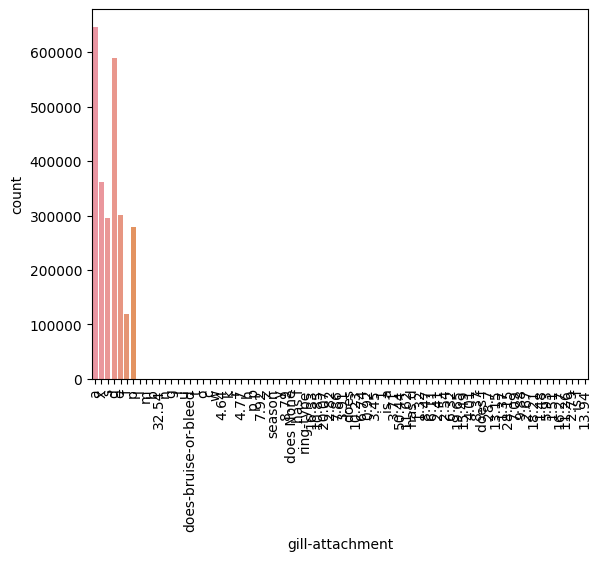

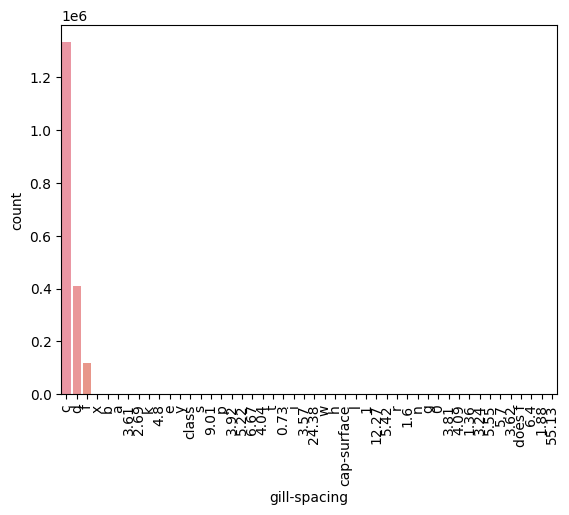

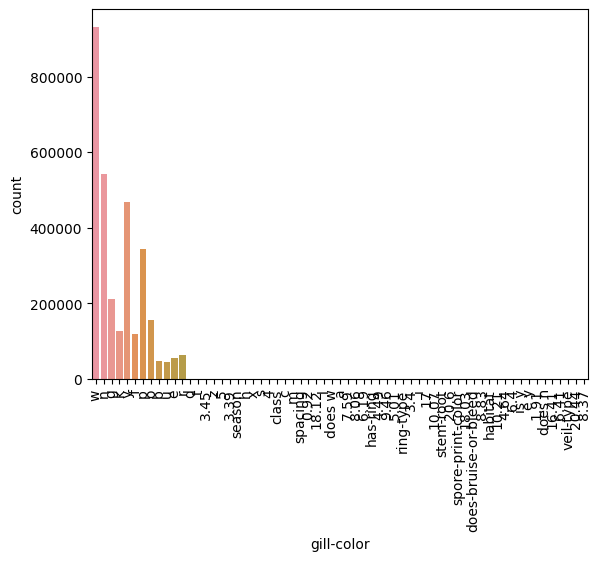

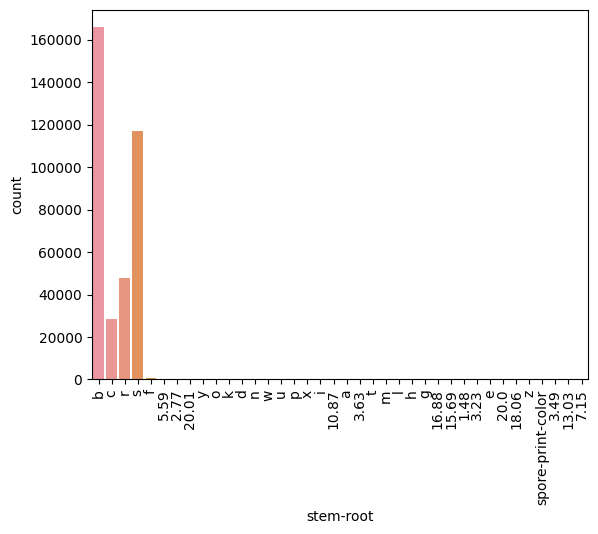

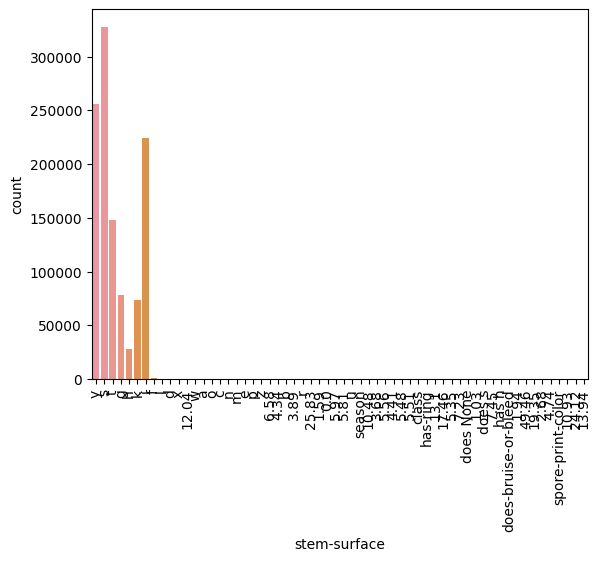

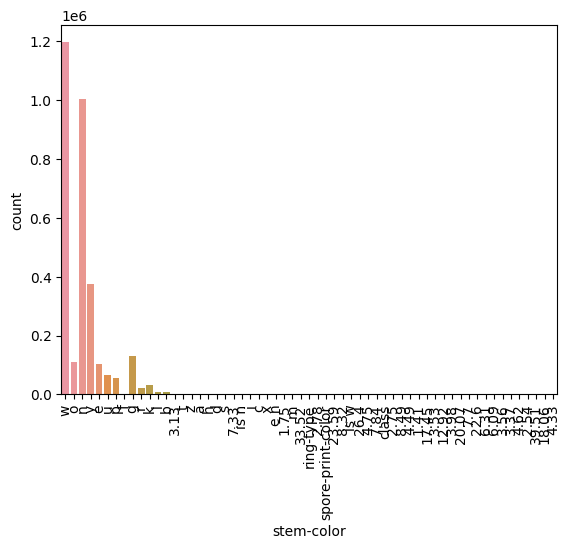

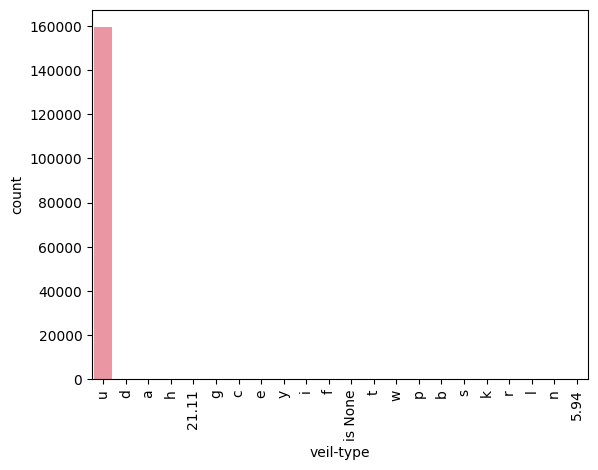

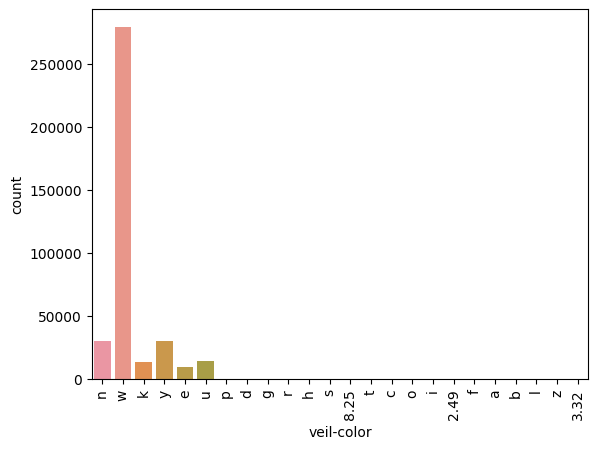

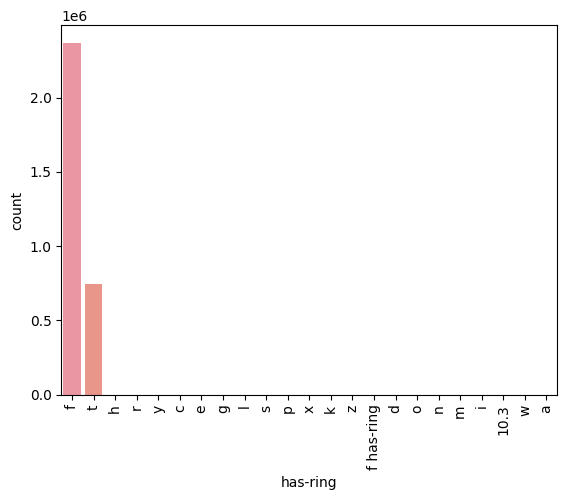

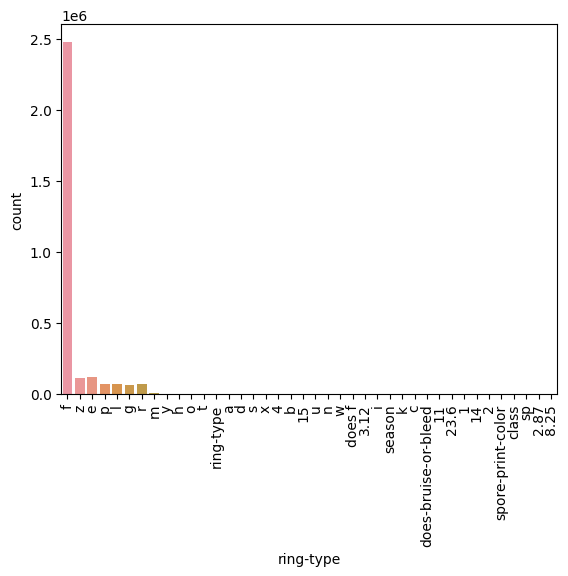

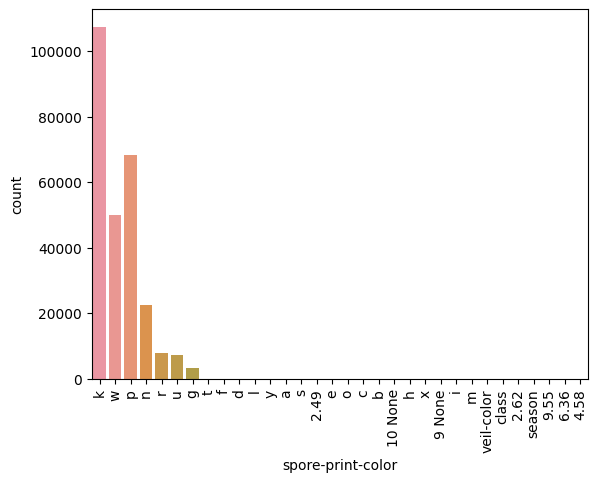

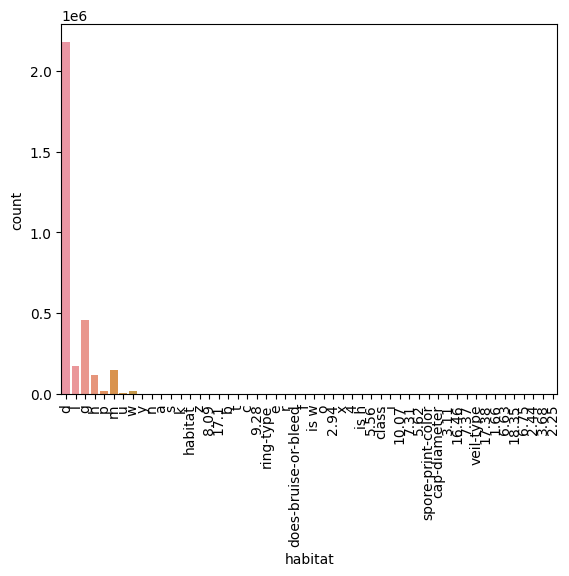

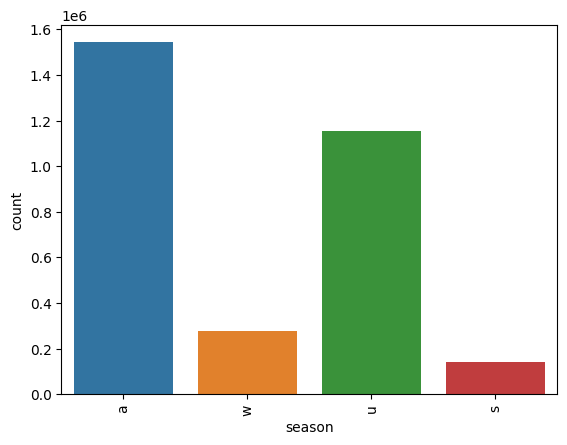

In [10]:
cat_features = train.select_dtypes(include='object').columns

for i in range(len(cat_features)):
    sns.countplot(x=cat_features[i], data=train)
    plt.xticks(rotation=90)
    plt.show()

# X, y, train test split add new data

In [11]:
X = train.drop(columns = ['id', 'class'], axis =1)
y = train['class']
X_total = test.drop(columns = ['id'], axis =1)



label_encoder = LabelEncoder() 

y = label_encoder.fit_transform(y) 


enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
org_cat_col = X.select_dtypes(include='object').columns

X[org_cat_col] = enc.fit_transform(X[org_cat_col].astype(str)) 
X_total[org_cat_col] = enc.transform(X_total[org_cat_col].astype(str))



X_nan_col = X.columns[X.isna().any()].tolist()
X_total_nan = X_total.columns[X_total.isna().any()].tolist()

columns_with_nan = list(set(X_nan_col) | set(X_total_nan))

KNN_imputer = KNNImputer(n_neighbors=5)

X[columns_with_nan] = KNN_imputer.fit_transform(X[columns_with_nan])
X_total[columns_with_nan] = KNN_imputer.transform(X_total[columns_with_nan])
    
# output_df = PolynomialFeatures_labeled(X[X.columns],2)
# output_df_t = PolynomialFeatures_labeled(X_total[X.columns],2)

# pca = PCA(n_components=1)
# X['pca'] = pca.fit_transform(output_df)
# X_total['pca'] = pca.transform(output_df_t)

# print(f"X shape PolynomialFeatures_labeled :{X.shape} , y shape :{y.shape}")
# print(f"X_total shape :{X_total.shape}")
# print(f'Columns: {X.columns}')

# transform = PowerTransformer(method='yeo-johnson')
# transform2 = QuantileTransformer(n_quantiles=10, random_state=random_state)

# for i in plot_col[1:]:
#     X[i+'+log'] = (X[i]+1).transform(np.log)
#     X_total[i+'+log'] =(X_total[i]+1).transform(np.log)
    
#     X[i+'+log1'] = (X[i]+1).transform(np.log1p)
#     X_total[i+'+log1'] =(X_total[i]+1).transform(np.log1p)
    
#     X[i+'+y_j'] = transform.fit_transform(X[[i]])
#     X_total[i+'+y_j'] = transform.fit_transform(X_total[[i]])
    
#     X[i+'+q_t'] = transform2.fit_transform(X[[i]])
#     X_total[i+'+q_t'] = transform2.fit_transform(X_total[[i]])
       
#     X[i+'+sqrt'] = (X[i]+1).transform(np.sqrt)
#     X_total[i+'+sqrt'] =(X_total[i]+1).transform(np.sqrt)

X = variance_threshold(X,0.04)
list_name = (X.columns)
X_total = X_total[list_name]

print('Shape threshold X =', X.shape,',',"Shape X_total =", X_total.shape)
print(f'Columns: {X.columns}')


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=random_state, stratify = y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Shape threshold X = (3116945, 20) , Shape X_total = (2077964, 20)
Columns: Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')
(2088353, 20)
(1028592, 20)
(2088353,)
(1028592,)


In [12]:
sampler = RandomOverSampler(random_state=random_state)

X_train, y_train = sampler.fit_resample(X_train, y_train)

# Optuna serch

In [13]:
def objective(trial):
        
    params = {
        'iterations': trial.suggest_int('iterations', 100, 400),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 1e-2, log=True),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 1.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 5.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
    }

    model = CatBoostClassifier(**params, verbose=0)
    
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=35, n_jobs=4)

print("Best parameters: ", study.best_params)
print("Best accuracy: ", study.best_value)
cat_params = study.best_params

[I 2024-08-17 16:18:51,455] A new study created in memory with name: no-name-de4c7480-ef16-4a48-a6f2-692f7a340774
[I 2024-08-17 16:22:53,305] Trial 1 finished with value: 0.5836687432918009 and parameters: {'iterations': 219, 'depth': 3, 'learning_rate': 0.006879294471523608, 'l2_leaf_reg': 0.005408913711904237, 'border_count': 120, 'random_strength': 0.0354809998822354, 'bagging_temperature': 0.05673529515723719, 'scale_pos_weight': 3.406148360834217, 'od_type': 'Iter', 'od_wait': 12, 'subsample': 0.7927404522525868, 'colsample_bylevel': 0.5528868796599635}. Best is trial 1 with value: 0.5836687432918009.
[I 2024-08-17 16:23:10,925] Trial 3 finished with value: 0.974997861153888 and parameters: {'iterations': 185, 'depth': 5, 'learning_rate': 0.03742113561714936, 'l2_leaf_reg': 0.0015200377966894407, 'border_count': 37, 'random_strength': 0.015793644395748135, 'bagging_temperature': 0.8497768405069213, 'scale_pos_weight': 1.0729965915717001, 'od_type': 'IncToDec', 'od_wait': 17, 'subs

Best parameters:  {'iterations': 242, 'depth': 10, 'learning_rate': 0.05103270756083859, 'l2_leaf_reg': 0.0056480157643332635, 'border_count': 122, 'random_strength': 0.07367416555058273, 'bagging_temperature': 0.35499584213002056, 'scale_pos_weight': 1.8658774913914218, 'od_type': 'IncToDec', 'od_wait': 20, 'subsample': 0.6213432584819499, 'colsample_bylevel': 0.5546852592726355}
Best accuracy:  0.9910780951047645


In [14]:
def objective(trial):

    
    params = {
    'objective': 'binary',
    'num_iterations': trial.suggest_int('num_iterations', 100, 400),
    'metric': 'binary_logloss',
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    'num_leaves': trial.suggest_int('num_leaves', 16, 256),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'feature_pre_filter': False,
    'min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 1e-8, 1.0),
    'max_bin': trial.suggest_int('max_bin', 100, 500),
}
    
    model = lgb.LGBMClassifier(**params, early_stopping_rounds=3, verbose=-1)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=35)

print("Best parameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

lgb_params = study.best_params

[I 2024-08-17 17:12:00,807] A new study created in memory with name: no-name-aeca864f-38ee-4bea-8846-2b508e4b5407
[I 2024-08-17 17:13:49,804] Trial 0 finished with value: 0.9918811345995302 and parameters: {'num_iterations': 171, 'lambda_l1': 1.8591850347427918e-08, 'lambda_l2': 0.20841582112287982, 'num_leaves': 113, 'feature_fraction': 0.6257696360352502, 'bagging_fraction': 0.8713670817266923, 'bagging_freq': 4, 'min_child_samples': 50, 'min_gain_to_split': 0.2021119582789563, 'max_bin': 184}. Best is trial 0 with value: 0.9918811345995302.
[I 2024-08-17 17:16:40,885] Trial 1 finished with value: 0.9918325244606219 and parameters: {'num_iterations': 307, 'lambda_l1': 8.226179347806699e-08, 'lambda_l2': 0.023299627322462754, 'num_leaves': 87, 'feature_fraction': 0.5782393196833823, 'bagging_fraction': 0.7976967113807356, 'bagging_freq': 6, 'min_child_samples': 54, 'min_gain_to_split': 0.0032997033165684145, 'max_bin': 221}. Best is trial 0 with value: 0.9918811345995302.
[I 2024-08-1

Best parameters:  {'num_iterations': 375, 'lambda_l1': 6.464097324288126e-08, 'lambda_l2': 0.06565173299133986, 'num_leaves': 220, 'feature_fraction': 0.43579620518063805, 'bagging_fraction': 0.783863049416504, 'bagging_freq': 2, 'min_child_samples': 60, 'min_gain_to_split': 1.6569415665376438e-06, 'max_bin': 211}
Best accuracy:  0.9922350164107829


In [15]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 400),
        "verbosity": 0,
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-8, 100, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "logloss",
    }

    model = XGBClassifier(**param, n_jobs=-1, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=35)

print("Best parameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

xgb_params = study.best_params

[I 2024-08-17 18:53:28,876] A new study created in memory with name: no-name-2ca09206-b7e2-40a0-bb8b-996088d253ef
[I 2024-08-17 18:57:21,864] Trial 0 finished with value: 0.786167887753356 and parameters: {'n_estimators': 286, 'lambda': 0.0003767182447424872, 'alpha': 0.013716627004079766, 'colsample_bytree': 0.49217791693459284, 'max_depth': 4, 'min_child_weight': 9.885102559633339, 'learning_rate': 1.1594314500865219e-05, 'gamma': 0.03783296473348467}. Best is trial 0 with value: 0.786167887753356.
[I 2024-08-17 19:05:18,598] Trial 1 finished with value: 0.9812675968702849 and parameters: {'n_estimators': 378, 'lambda': 0.010449136691924155, 'alpha': 0.02616490511975166, 'colsample_bytree': 0.21375175411081823, 'max_depth': 10, 'min_child_weight': 29.468456064030285, 'learning_rate': 0.0018264038023697749, 'gamma': 3.3219059462577703e-07}. Best is trial 1 with value: 0.9812675968702849.
[I 2024-08-17 19:09:05,185] Trial 2 finished with value: 0.9673427364786038 and parameters: {'n_es

Best parameters:  {'n_estimators': 197, 'lambda': 1.0971930185085859, 'alpha': 11.528204498386174, 'colsample_bytree': 0.38019024294423087, 'max_depth': 10, 'min_child_weight': 0.00015782743935933253, 'learning_rate': 0.16243382528971853, 'gamma': 5.966556894780952e-08}
Best accuracy:  0.9922097391385506


# ML model

In [16]:
cat_params_1 = {'iterations': 100, 'depth': 3, 'learning_rate': 0.1}
lgb_params_1 = {'n_estimators': 100, 'ax_depth': 3, 'learning_rate': 0.1}
xgb_params_1 = {'n_estimators': 100, 'ax_depth': 3, 'learning_rate': 0.1}


level0 = list()
level0.append(('cat', CatBoostClassifier(**cat_params, verbose=0)))
level0.append(('lgb', lgb.LGBMClassifier(**lgb_params, verbose=-1)))
level0.append(('xgb', XGBClassifier(**xgb_params)))
level0.append(('calib_xgb', create_calibrated_classifier(XGBClassifier(**xgb_params))))
level0.append(('calib_lgb', create_calibrated_classifier(lgb.LGBMClassifier(**lgb_params, verbose=-1))))
level0.append(('calib_cat', create_calibrated_classifier(CatBoostClassifier(**cat_params, verbose=0))))
level0.append(('cat_1', CatBoostClassifier(**cat_params_1, verbose=0)))
level0.append(('lgb_1', lgb.LGBMClassifier(**lgb_params_1, verbose=-1)))
level0.append(('xgb_1', XGBClassifier(**xgb_params_1)))

# define meta learner model
level1 = lgb.LGBMClassifier(verbose=-1)
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

roc_auc_score_value = roc_auc_score(y_test, y_pred)
print(f'Roc_auc Score: {roc_auc_score_value:.4f}')

Roc_auc Score: 0.9922


In [17]:
test_pred = model.predict(X_total)

test_pred_class = label_encoder.inverse_transform(test_pred)

In [18]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
sub['class'] = test_pred_class 
sub.to_csv('submission.csv', index=False)
sub

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e
